In [8]:
!pip install pycryptodomex


In [9]:
import os
import time
import psutil
from Cryptodome.Cipher import AES
from Cryptodome.Util.Padding import pad, unpad
from Cryptodome.Random import get_random_bytes
import matplotlib.pyplot as plt

# AES-256 Encryption Implementation
class AES256Encryption:
    def __init__(self):
        self.block_size = 16
        self.key_size = 32

    def generate_key(self):
        """Generate a 256-bit AES key."""
        return get_random_bytes(self.key_size)

    def encrypt(self, plaintext, key, padding_scheme="PKCS7"):
        """Encrypt plaintext using AES-256 CBC mode with proper padding."""
        cipher = AES.new(key, AES.MODE_CBC)
        if padding_scheme == "PKCS7":
            padded_plaintext = pad(plaintext, self.block_size)
        elif padding_scheme == "ISO7816":
            padded_plaintext = plaintext + b"\x80" + b"\x00" * (self.block_size - len(plaintext) % self.block_size - 1)
        elif padding_scheme == "Zero":
            padded_plaintext = plaintext + b"\x00" * (self.block_size - len(plaintext) % self.block_size)
        else:
            raise ValueError("Unsupported padding scheme")
        ciphertext = cipher.encrypt(padded_plaintext)
        return cipher.iv + ciphertext

    def decrypt(self, ciphertext, key, padding_scheme="PKCS7"):
        """Decrypt ciphertext using AES-256 CBC mode with explicit padding removal."""
        iv = ciphertext[:self.block_size]
        ciphertext = ciphertext[self.block_size:]
        cipher = AES.new(key, AES.MODE_CBC, iv)
        padded_plaintext = cipher.decrypt(ciphertext)
        if padding_scheme == "PKCS7":
            plaintext = unpad(padded_plaintext, self.block_size)
        elif padding_scheme == "Zero":
            plaintext = padded_plaintext.rstrip(b"\x00")
        elif padding_scheme == "ISO7816":
            plaintext = padded_plaintext.rstrip(b"\x00").rstrip(b"\x80")
        else:
            raise ValueError("Unsupported padding scheme")
        return plaintext

    def encrypt_file(self, input_file, output_file, key, padding_scheme="PKCS7"):
        """Encrypt a file and save the encrypted content to a new file.

        Args:
            input_file (str): Path to the input file to be encrypted.
            output_file (str): Path to save the encrypted file.
            key (bytes): The 256-bit encryption key.
            padding_scheme (str): Padding scheme to use ("PKCS7", "Zero").
        """
        try:
            with open(input_file, 'rb') as f:
                plaintext = f.read()
            ciphertext = self.encrypt(plaintext, key, padding_scheme)
            if ciphertext:
                with open(output_file, 'wb') as f:
                    f.write(ciphertext)
        except Exception as e:
            print(f"Error during file encryption: {e}")

    def decrypt_file(self, input_file, output_file, key, padding_scheme="PKCS7"):
        """Decrypt an encrypted file and save the decrypted content.

        Args:
            input_file (str): Path to the encrypted file.
            output_file (str): Path to save the decrypted file.
            key (bytes): The 256-bit decryption key.
            padding_scheme (str): Padding scheme to use ("PKCS7", "Zero").
        """
        try:
            with open(input_file, 'rb') as f:
                ciphertext = f.read()
            plaintext = self.decrypt(ciphertext, key, padding_scheme)
            if plaintext:
                with open(output_file, 'wb') as f:
                    f.write(plaintext)
        except Exception as e:
            print(f"Error during file decryption: {e}")



In [10]:
!pip install psutil memory-profiler pycryptodome

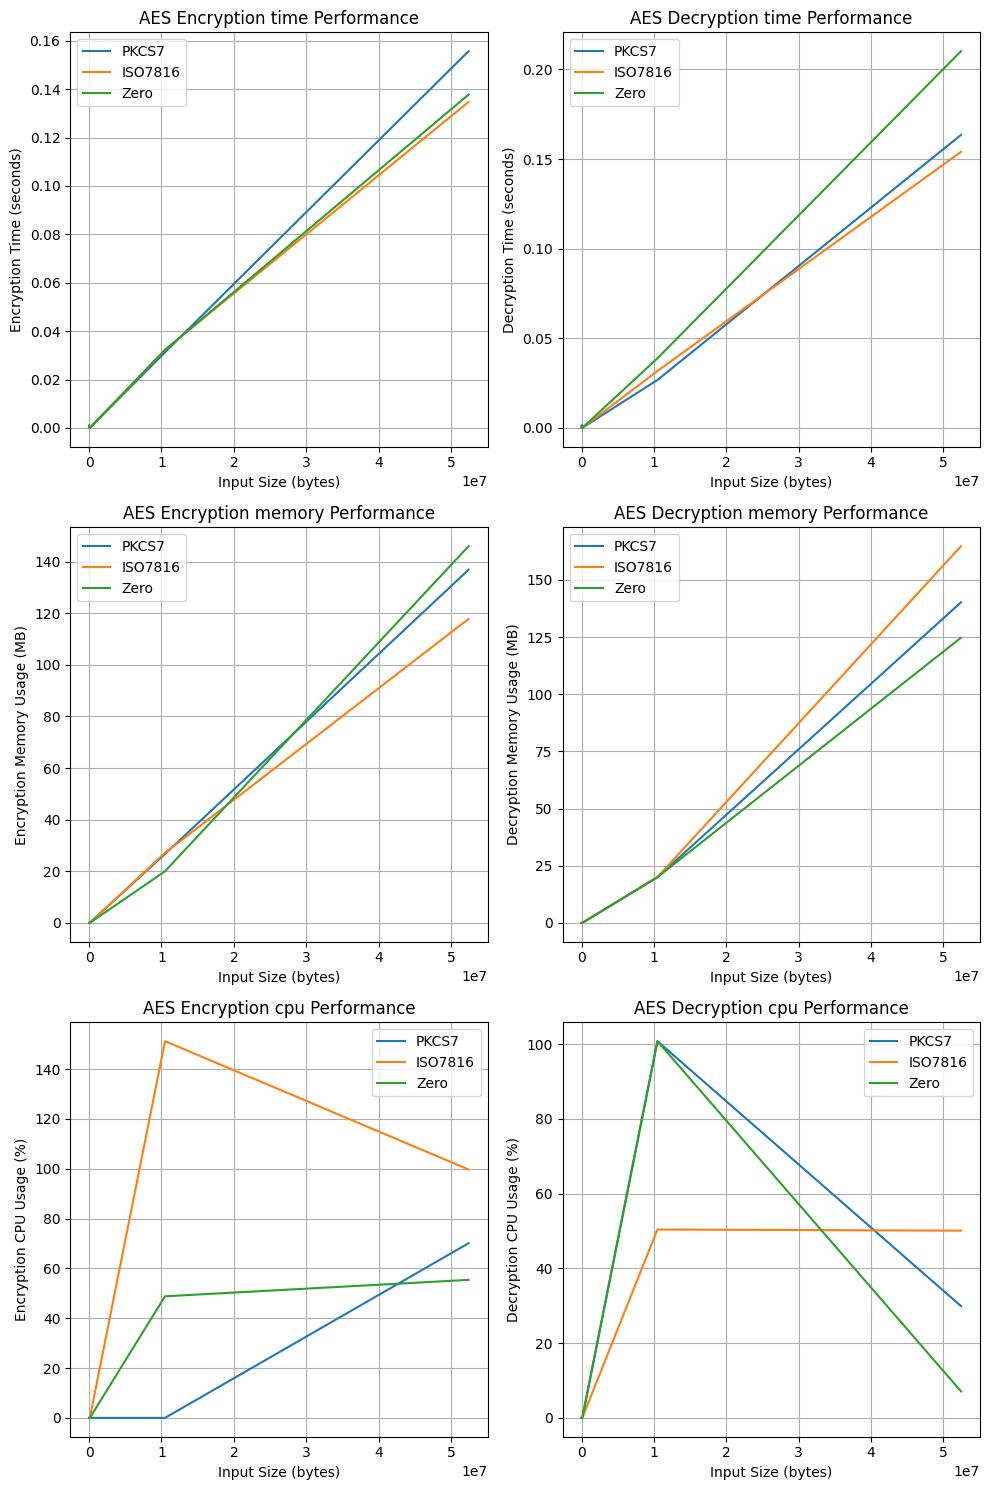

In [11]:
import psutil
from memory_profiler import memory_usage
import os
from Cryptodome.Cipher import AES
from Cryptodome.Util.Padding import pad, unpad
from Cryptodome.Random import get_random_bytes
import time
import matplotlib.pyplot as plt

# --- Code Snippets for Memory and CPU Usage ---
def measure_memory(func, *args, **kwargs):
    mem_usage = memory_usage((func, args, kwargs), interval=0.1, timeout=None)
    return max(mem_usage) - min(mem_usage)


def measure_cpu_and_time(func, *args, **kwargs):
    start_time = time.time()
    process = psutil.Process()
    cpu_start = process.cpu_percent(interval=None)
    func(*args, **kwargs)
    cpu_end = process.cpu_percent(interval=None)
    elapsed_time = time.time() - start_time
    return elapsed_time, cpu_end - cpu_start


def extended_performance_test():
    """
    Test AES performance: speed, memory, and CPU utilization with encryption and decryption.
    """
    aes = AES256Encryption()
    key = aes.generate_key()
    input_sizes = [
        1 * 1024,  # 1KB
        10 * 1024,  # 10KB
        100 * 1024,  # 100KB
        10 * 1024 * 1024,  # 10MB
        50 * 1024 * 1024,  # 50MB
    ]
    padding_schemes = ["PKCS7", "ISO7816", "Zero"]
    results = {
        "encryption_time": {}, "decryption_time": {},
        "encryption_memory": {}, "decryption_memory": {},
        "encryption_cpu": {}, "decryption_cpu": {}
    }

    for padding_scheme in padding_schemes:
        results["encryption_time"][padding_scheme] = []
        results["decryption_time"][padding_scheme] = []
        results["encryption_memory"][padding_scheme] = []
        results["decryption_memory"][padding_scheme] = []
        results["encryption_cpu"][padding_scheme] = []
        results["decryption_cpu"][padding_scheme] = []

        for size in input_sizes:
            data = b'A' * size  # Uniform data: repeated 'A' characters
            key = get_random_bytes(32)

            # Measure encryption time, memory, and CPU usage
            enc_time, enc_cpu = measure_cpu_and_time(aes.encrypt, data, key, padding_scheme)
            enc_memory = measure_memory(aes.encrypt, data, key, padding_scheme)

            # Perform encryption to get ciphertext
            ciphertext = aes.encrypt(data, key, padding_scheme)

            # Measure decryption time, memory, and CPU usage
            dec_time, dec_cpu = measure_cpu_and_time(aes.decrypt, ciphertext, key, padding_scheme)
            dec_memory = measure_memory(aes.decrypt, ciphertext, key, padding_scheme)

            # Record encryption metrics
            results["encryption_time"][padding_scheme].append(enc_time)
            results["encryption_memory"][padding_scheme].append(enc_memory)
            results["encryption_cpu"][padding_scheme].append(enc_cpu)

            # Record decryption metrics
            results["decryption_time"][padding_scheme].append(dec_time)
            results["decryption_memory"][padding_scheme].append(dec_memory)
            results["decryption_cpu"][padding_scheme].append(dec_cpu)

    # Visualization
    fig, axs = plt.subplots(3, 2, figsize=(10, 15))

    metrics = [
        ("encryption_time", "Encryption Time (seconds)"),
        ("decryption_time", "Decryption Time (seconds)"),
        ("encryption_memory", "Encryption Memory Usage (MB)"),
        ("decryption_memory", "Decryption Memory Usage (MB)"),
        ("encryption_cpu", "Encryption CPU Usage (%)"),
        ("decryption_cpu", "Decryption CPU Usage (%)"),
    ]

    for i, (metric, ylabel) in enumerate(metrics):
        ax = axs[i//2, i%2]  # Use 2 rows, 3 columns for subplot positioning
        for padding_scheme, values in results[metric].items():
            ax.plot(input_sizes, values, label=f"{padding_scheme}")
        ax.set_xlabel("Input Size (bytes)")
        ax.set_ylabel(ylabel)
        ax.set_title(f"AES {metric.replace('_', ' ').capitalize()} Performance")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()


# --- Run the Extended Performance Test ---
extended_performance_test()


In [12]:
import pandas as pd
def measure_encryption_decryption_times():
    aes = AES256Encryption()
    key = aes.generate_key()
    input_sizes = [1 * 1024, 10 * 1024, 100 * 1024, 1 * 1024 * 1024, 10 * 1024 * 1024]  # Sizes in bytes

    results = []

    for size in input_sizes:
        plaintext = b'A' * size

        # Measure encryption time
        start_time = time.time()
        ciphertext = aes.encrypt(plaintext, key)
        encryption_time = (time.time() - start_time) * 1000  # Convert to milliseconds

        # Measure decryption time
        start_time = time.time()
        aes.decrypt(ciphertext, key)
        decryption_time = (time.time() - start_time) * 1000  # Convert to milliseconds

        # Store results
        results.append({"Input Size (KB)": size // 1024,
                        "Encryption Time (ms)": round(encryption_time, 2),
                        "Decryption Time (ms)": round(decryption_time, 2)})

    return results

def display_results_in_colab(results):
    """Display the results as a table in Google Colab."""
    df = pd.DataFrame(results)
    return df

results = measure_encryption_decryption_times()
df = display_results_in_colab(results)
print(df)  # Display the table in the Colab console

   Input Size (KB)  Encryption Time (ms)  Decryption Time (ms)
0                1                  0.00                  0.00
1               10                  0.00                  0.00
2              100                  0.00                  0.00
3             1024                 15.26                  1.19
4            10240                 35.90                 31.08


# Security Analysis

## Common Security Considerations Across All Padding Schemes

1. **Potential Vulnerabilities**  
   - Key compromise can lead to the exposure of encrypted data.  
   - Insecure key storage increases risk.  

2. **Mitigation Strategies**  
   - Use secure channels for key distribution (e.g., TLS).  
   - Store keys in hardware security modules (HSMs) or secure key management systems.  

3. **Impact of Key Sizes**  
   - AES-128, AES-192, and AES-256 offer different levels of security.  
     AES-256 provides the highest brute-force resistance.

4. **Side-Channel Attacks**  
   - Timing attacks and power analysis can expose cryptographic operations.  
     Countermeasures include constant-time algorithms and noise injection.

---

## PKCS7 Padding

### Additional Security Considerations:
- Padding oracle attacks can occur if error messages reveal padding issues.

### Additional Mitigation Strategies:
- Ensure error messages do not reveal padding validity.

---

## Zero Padding

### Additional Security Considerations:
- Data loss or misinterpretation can occur if the plaintext ends with zero bytes.  

### Additional Mitigation Strategies:
- Ensure the plaintext length is well-defined to avoid ambiguity.

---

## ISO7816 Padding

### Additional Security Considerations:
- Similar to PKCS7, padding oracle attacks can occur if error messages reveal padding issues.

### Additional Mitigation Strategies:
- Ensure error messages do not reveal padding validity.


In [13]:
import os
import psutil
import time

def test_aes_encryption():
    aes = AES256Encryption()
    key = aes.generate_key()
    process = psutil.Process(os.getpid())

    def get_system_metrics():
        memory_before = process.memory_info().rss
        cpu_before = process.cpu_percent(interval=None)
        return memory_before, cpu_before

    def print_metrics(test_name, memory_before, cpu_before, memory_after, cpu_after, file_size, encryption_time, decryption_time):
        print(f"{test_name} - File Size: {file_size} bytes")
        print(f"{test_name} - Encryption Time: {encryption_time:.6f} seconds")
        print(f"{test_name} - Decryption Time: {decryption_time:.6f} seconds")
        print(f"{test_name} - Memory Usage: {memory_after - memory_before} bytes")
        print(f"{test_name} - CPU Usage: {cpu_after - cpu_before:.2f}%\n")

    # Test 1: Encrypt small test file
    input_file = "sample_small.txt"
    encrypted_file = "encrypted_sample_small.txt"
    decrypted_file = "decrypted_sample_small.txt"

    with open(input_file, 'wb') as f:
        f.write(b"This is a test file for AES file encryption.")

    file_size = os.path.getsize(input_file)
    memory_before, cpu_before = get_system_metrics()

    start_time = time.time()
    aes.encrypt_file(input_file, encrypted_file, key)
    encryption_time = time.time() - start_time

    start_time = time.time()
    aes.decrypt_file(encrypted_file, decrypted_file, key)
    decryption_time = time.time() - start_time

    memory_after, cpu_after = get_system_metrics()
    with open(input_file, 'rb') as f1, open(decrypted_file, 'rb') as f2:
        assert f1.read() == f2.read(), "Test 1 failed!"

    # print_metrics("Test 1", memory_before, cpu_before, memory_after, cpu_after, file_size, encryption_time, decryption_time)

    # Test 2: Encrypt medium size test file
    input_file = "sample_medium.txt"
    encrypted_file = "encrypted_sample_medium.txt"
    decrypted_file = "decrypted_sample_medium.txt"

    with open(input_file, 'wb') as f:
        f.write(b"This is a test file for AES file encryption." * 1000)

    file_size = os.path.getsize(input_file)
    memory_before, cpu_before = get_system_metrics()

    start_time = time.time()
    aes.encrypt_file(input_file, encrypted_file, key)
    encryption_time = time.time() - start_time

    start_time = time.time()
    aes.decrypt_file(encrypted_file, decrypted_file, key)
    decryption_time = time.time() - start_time

    memory_after, cpu_after = get_system_metrics()
    with open(input_file, 'rb') as f1, open(decrypted_file, 'rb') as f2:
        assert f1.read() == f2.read(), "Test 2 failed!"

    # print_metrics("Test 2", memory_before, cpu_before, memory_after, cpu_after, file_size, encryption_time, decryption_time)

    # Test 3: Encrypt large test file
    input_file = "sample_large.txt"
    encrypted_file = "encrypted_sample_large.txt"
    decrypted_file = "decrypted_sample_large.txt"

    with open(input_file, 'wb') as f:
        f.write(b"This is a test file for AES file encryption." * 1024* 1024)

    file_size = os.path.getsize(input_file)
    memory_before, cpu_before = get_system_metrics()

    start_time = time.time()
    aes.encrypt_file(input_file, encrypted_file, key)
    encryption_time = time.time() - start_time

    start_time = time.time()
    aes.decrypt_file(encrypted_file, decrypted_file, key)
    decryption_time = time.time() - start_time

    memory_after, cpu_after = get_system_metrics()
    with open(input_file, 'rb') as f1, open(decrypted_file, 'rb') as f2:
        assert f1.read() == f2.read(), "Test 3 failed!"

    # print_metrics("Test 3", memory_before, cpu_before, memory_after, cpu_after, file_size, encryption_time, decryption_time)

    print("All tests passed!")

# Run tests
test_aes_encryption()


All tests passed!


In [14]:
#Testing
import os
import psutil
import time

def test_aes_encryption():
    aes = AES256Encryption()
    key = aes.generate_key()
    process = psutil.Process(os.getpid())

    # Test 4: Encrypt large test file
    input_file = "sample_large.txt"
    encrypted_file = "encrypted_sample_large.txt"
    decrypted_file = "decrypted_sample_large.txt"

    with open(input_file, 'wb') as f:
        f.write(b"This is a test file for AES file encryption." * 100000)

    file_size = os.path.getsize(input_file)
    memory_before = process.memory_info().rss
    cpu_before = process.cpu_percent(interval=None)

    start_time = time.time()
    aes.encrypt_file(input_file, encrypted_file, key, padding_scheme="ISO7816")
    encryption_time = time.time() - start_time

    start_time = time.time()
    aes.decrypt_file(encrypted_file, decrypted_file, key, padding_scheme="ISO7816")
    decryption_time = time.time() - start_time

    memory_after = process.memory_info().rss
    cpu_after = process.cpu_percent(interval=None)

    with open(input_file, 'rb') as f1, open(decrypted_file, 'rb') as f2:
        assert f1.read() == f2.read(), "Test 3 failed!"

    # print(f"Test 3 - File Size: {file_size} bytes")
    # print(f"Test 3 - Encryption Time: {encryption_time:.6f} seconds")
    # print(f"Test 3 - Decryption Time: {decryption_time:.6f} seconds")
    # print(f"Test 3 - Memory Usage: {memory_after - memory_before} bytes")
    # print(f"Test 3 - CPU Usage: {cpu_after - cpu_before:.2f}%\n")

    # print("All tests passed!")

    # Test 5: Encrypt large test file
    input_file = "sample_large.txt"
    encrypted_file = "encrypted_sample_large.txt"
    decrypted_file = "decrypted_sample_large.txt"

    with open(input_file, 'wb') as f:
        f.write(b"This is a test file for AES file encryption." * 100000)

    file_size = os.path.getsize(input_file)
    memory_before = process.memory_info().rss
    cpu_before = process.cpu_percent(interval=None)

    start_time = time.time()
    aes.encrypt_file(input_file, encrypted_file, key, padding_scheme="Zero")
    encryption_time = time.time() - start_time

    start_time = time.time()
    aes.decrypt_file(encrypted_file, decrypted_file, key, padding_scheme="Zero")
    decryption_time = time.time() - start_time

    memory_after = process.memory_info().rss
    cpu_after = process.cpu_percent(interval=None)

    with open(input_file, 'rb') as f1, open(decrypted_file, 'rb') as f2:
        assert f1.read() == f2.read(), "Test 3 failed!"

    # print(f"Test 3 - File Size: {file_size} bytes")
    # print(f"Test 3 - Encryption Time: {encryption_time:.6f} seconds")
    # print(f"Test 3 - Decryption Time: {decryption_time:.6f} seconds")
    # print(f"Test 3 - Memory Usage: {memory_after - memory_before} bytes")
    # print(f"Test 3 - CPU Usage: {cpu_after - cpu_before:.2f}%\n")

    print("All tests passed!")

# Run tests
test_aes_encryption()


All tests passed!
